In [2]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl
from utils import *

# Parse AST-file

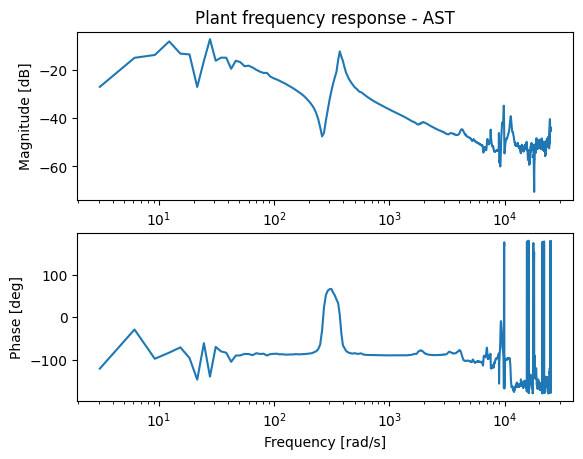

In [3]:
ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')


Y = ast.plant_freq_response.values
Y = np.array(Y)
mag = np.abs(Y)
phase = np.angle(Y)
omega = ast.plant_freq_response.freqs_hz * 2*np.pi


plt.subplot(2,1,1)
plt.semilogx(omega, 20*np.log10(mag))
plt.title('Plant frequency response - AST')
plt.ylabel('Magnitude [dB]')

plt.subplot(2,1,2)
plt.semilogx(omega, np.rad2deg(phase))
plt.ylabel('Phase [deg]')
#plt.title('Phase')
plt.xlabel('Frequency [rad/s]')

save_fig('plant_ast')
plt.show()

## Select frequency range of interest

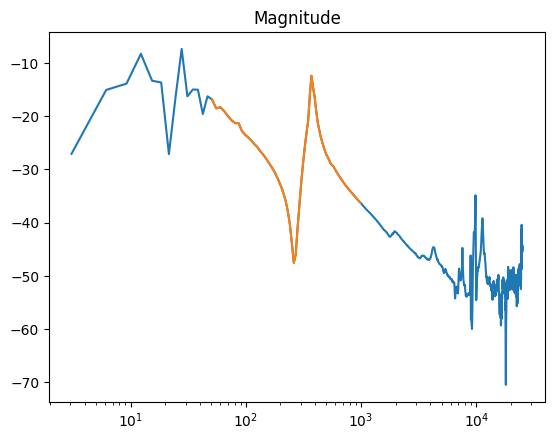

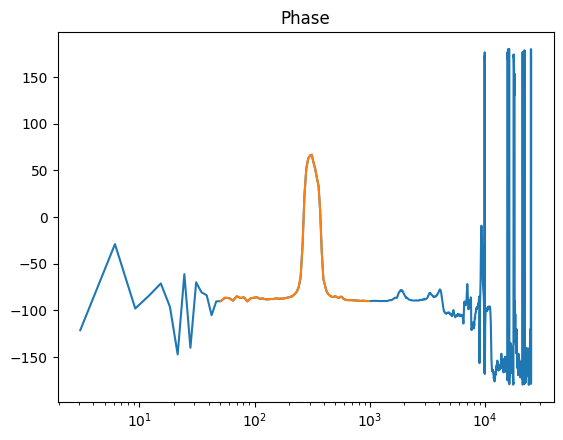

In [4]:
indx = omega > 50
indx1 = omega < 1000
indx = indx & indx1


mag_H = mag[indx]
phase_H = phase[indx]
omega_H = omega[indx]

plt.figure()
plt.semilogx(omega, 20*np.log10(mag))
plt.semilogx(omega_H, 20*np.log10(mag_H))
plt.title('Magnitude')


plt.figure()
plt.semilogx(omega, np.rad2deg(phase))
plt.semilogx(omega_H, np.rad2deg(phase_H))
plt.title('Phase')
plt.show()

# Identification

Zero:  w0 =  266.3612165041348 zeta =  0.04161182525315715
<TransferFunction>: sys[20]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     14.47 s^2 + 320.8 s + 1.027e+06
-----------------------------------------
s^3 + 32.86 s^2 + 1.399e+05 s + 2.933e+05



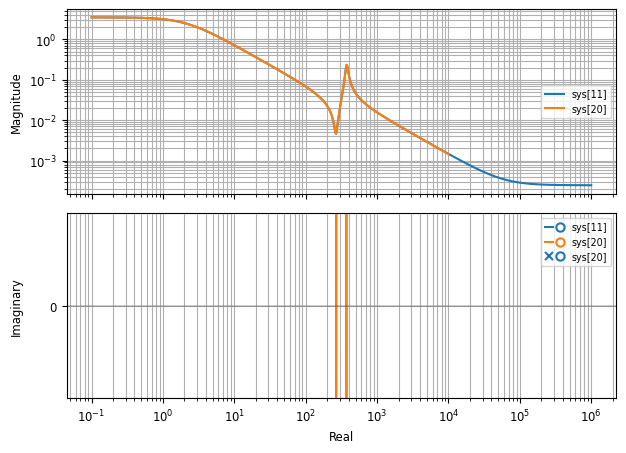

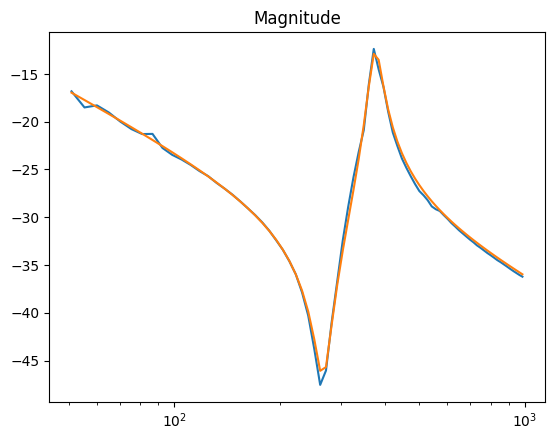

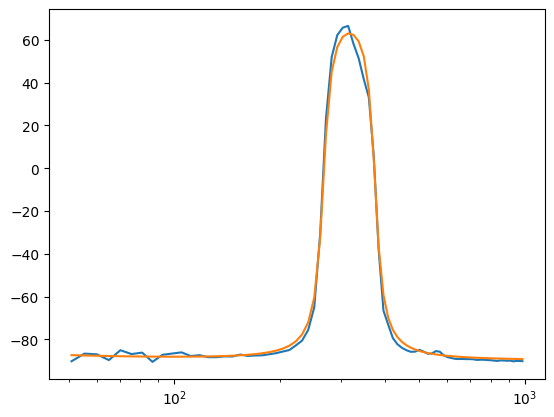

In [5]:
Gi,_,_= tf_freq_id.fit(omega_H, mag_H, phase_H,model_order=4)

Gi = ctrl.tf(Gi)
Gi = ctrl.minreal(Gi, verbose=False)


ctrl.bode(Gi)

# Remove unstale real zeros
unstable_zeros = 1.0
s = ctrl.tf('s')
for z in Gi.zeros():

    if z.imag > 0.01:
        w0 = np.abs(z)
        zeta = -np.real(z)/w0
        print("Zero: ",  "w0 = ", w0, "zeta = ", zeta)


    if np.abs(z.imag) < 0.01 and z.real > 0:
        unstable_zeros *= (s-np.real(z))/-np.abs(z.real)


Gi = Gi/unstable_zeros 
Gi = ctrl.minreal(Gi, verbose=False)

ctrl.bode(Gi)

ctrl.pzmap(Gi)

print(Gi)

GyH = ctrl.frequency_response(Gi, omega_H).response[0][0]

plt.figure()
plt.semilogx(omega_H, 20*np.log10(mag_H))
plt.semilogx(omega_H, 20*np.log10(np.abs(GyH)))
plt.title('Magnitude')

plt.figure()
plt.semilogx(omega_H, np.rad2deg(phase_H))
plt.semilogx(omega_H, np.rad2deg(np.angle(GyH)))
plt.show()


## Manually add high frequency components

0 states have been removed from the model


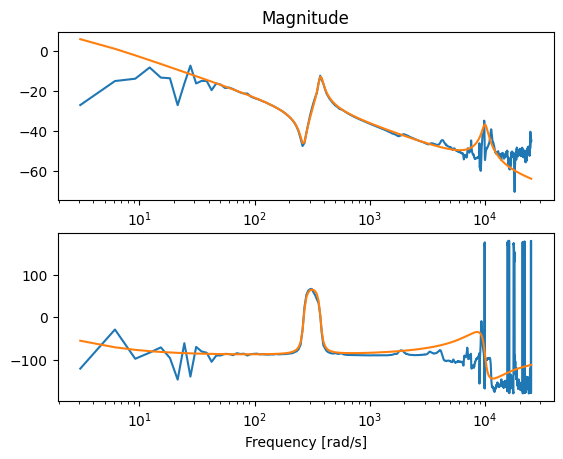

In [6]:

G = Gi * pt2(1e4,0.05)/pt2(1e4,0.5)

G = ctrl.minreal(G)

Gy = ctrl.frequency_response(G, omega).response[0][0]

plt.subplot(2,1,1)
plt.semilogx(omega, 20*np.log10(mag))
plt.semilogx(omega, 20*np.log10(np.abs(Gy)))
plt.title('Magnitude')


plt.subplot(2,1,2)
plt.semilogx(omega, np.rad2deg(phase))
plt.semilogx(omega, np.rad2deg(np.angle(Gy)))
plt.xlabel('Frequency [rad/s]')
save_fig('plant_identification')

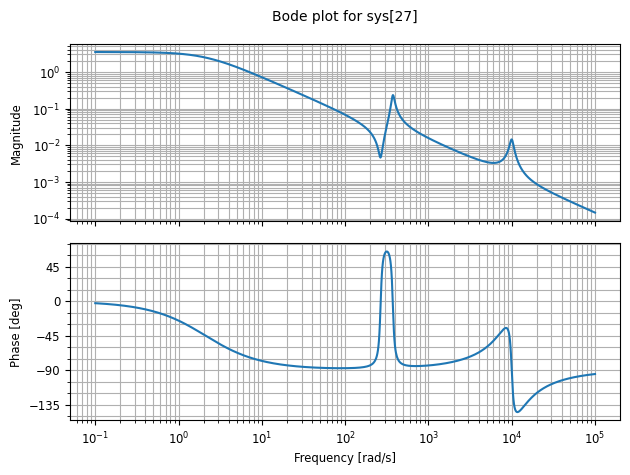

In [7]:
ctrl.bode_plot(G)

In [8]:
G

TransferFunction(array([1.44707431e+01, 1.45028212e+05, 1.45130879e+09, 4.23448419e+10,
       1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

In [9]:

def print_roots(roots):
    for z in roots:

        if z.imag > 0.01:
            w0 = np.abs(z)
            zeta = -np.real(z)/w0
            print("PT2: ",  "w0 = ", w0, "zeta = ", zeta)
        elif np.abs(z.imag) < 0.01:
            print("Real: ", z.real)


print("Zeros")
print_roots(G.zeros())
print("Poles")
print_roots(G.poles())



Zeros
PT2:  w0 =  9999.999999999996 zeta =  0.5000000000000003
PT2:  w0 =  266.3612165041341 zeta =  0.04161182525315884
Poles
PT2:  w0 =  10000.0 zeta =  0.04999999999999984
PT2:  w0 =  373.9453600549471 zeta =  0.04113635881529934
Real:  -2.097556148013025


# Model error (Additive error)

Ignoring errors below 100 rad/s

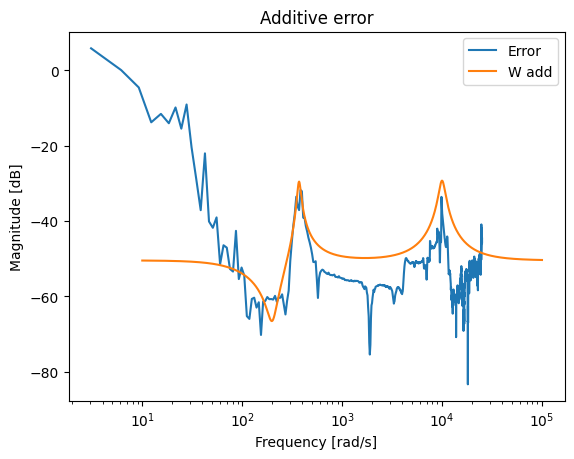

In [10]:
s = ctrl.tf('s')

#W_add = 2*1e-3*notch(370,0.8,370,0.04)*notch(1e4,0.8,1e4,0.07) * (s/1e4 + 1) / (s/(5*1e4) + 1)
W_add = 3*1e-3*notch(370,0.8,370,0.04)*notch(1e4,0.8,1e4,0.07) * pt2(200,1)/pt2(200,0.1)
error = np.abs(Y - Gy)


plt.figure()
plt.semilogx(omega, 20*np.log10(error),label='Error')
bodemag(W_add,label='W add')
plt.legend()
plt.title('Additive error')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Magnitude [dB]')
save_fig('additive_error')
plt.show()


# Multiplicative error

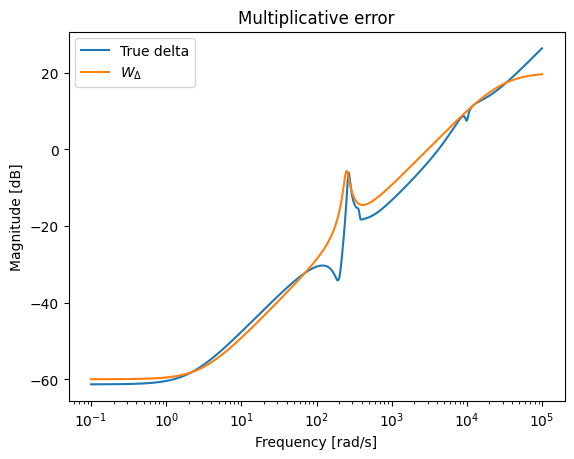

In [11]:
W_delta0 = W_add/G

W_delta = 1e-3*(s/3 + 1)/(s/3e4 + 1) * notch(250,0.5,250,0.08)

bodemag(W_delta0,label='True delta')
bodemag(W_delta,label=r'$W_\Delta$')
plt.title('Multiplicative error')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Magnitude [dB]')
plt.legend()
save_fig('W_delta')
plt.show()

## Write to txt file

In [12]:
def print_tf(tf,f):
    num = tf.num[0][0]
    den = tf.den[0][0]

    #num = np.flip(num)
    #den = np.flip(den)

    f.write(str(num))
    f.write('\n')
    f.write(str(den))

with open(r'tf_txt/W_delta.txt','w') as f:
    print_tf(W_delta,f)

# Including current control in plant

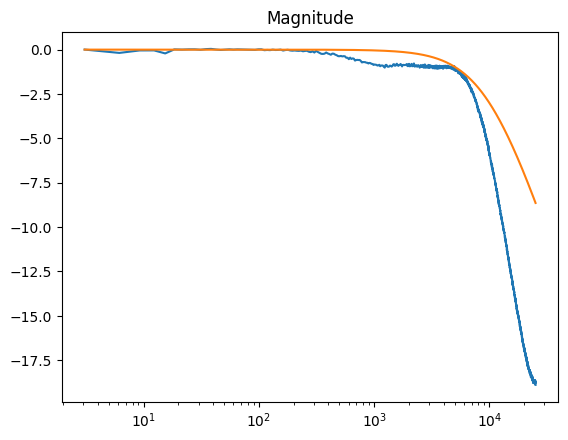

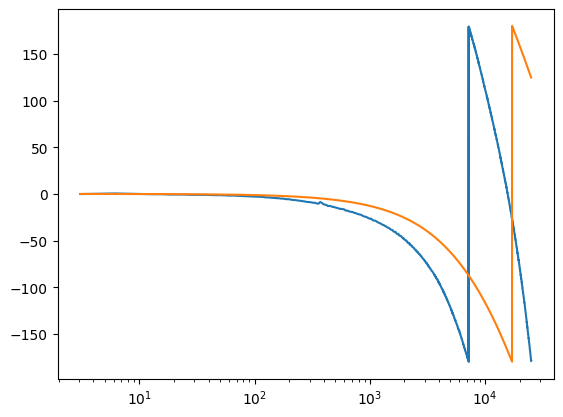

In [13]:


asct_GCY = ast.current_ctrl_freq_response.values
ast_GCY_omega = ast.current_ctrl_freq_response.freqs_hz * 2*np.pi

#Gc = pt2(8000,1.0)*tt.sinu_tf.pade(125*1e-6,2)
Gc = 1/(s/10000 + 1)*tt.sinu_tf.pade(125*1e-6,2)
#Gc = 1/(s/6000 + 1)*tt.sinu_tf.pade(225*1e-6,2)

Gcy = ctrl.frequency_response(Gc, ast_GCY_omega).response[0][0]

plt.figure()
plt.semilogx(ast_GCY_omega, 20*np.log10(np.abs(asct_GCY)))
plt.semilogx(ast_GCY_omega, 20*np.log10(np.abs(Gcy)))
plt.title('Magnitude')

plt.figure()
plt.semilogx(ast_GCY_omega, np.rad2deg(np.angle(asct_GCY)))
plt.semilogx(ast_GCY_omega, np.rad2deg(np.angle(Gcy)))


0 states have been removed from the model


TransferFunction(array([1.44707431e+01, 1.45028212e+05, 1.45130879e+09, 4.23448419e+10,
       1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

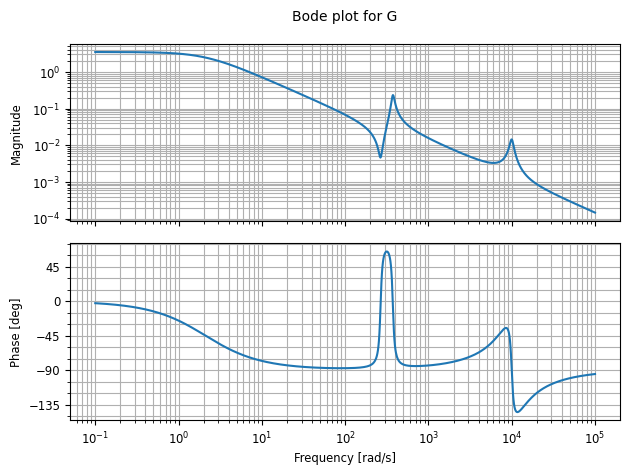

In [14]:
#Gf = Gc*G
Gf = G
Gf = ctrl.minreal(Gf)
Gf.name = 'G'

with open(r'tf_txt/Gf.txt','w') as f:
    print_tf(Gf,f)

ctrl.bode(Gf)
Gf

# Controller from AST

SpeedCtrl(Kp=22.242147839669272, Ti=0.035, Ts=0.00025, ref_mdl_active=True, ref_mdl_freq=37.567485311159444, ref_mdl_d=0.7071, ref_mdl_delay=0.0, act_value_filters=[], current_setp_filters=[PT2(freq=2000.0, damping=0.7071), SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)])
Torque setpoint filters:
PT2(freq=2000.0, damping=0.7071)
SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)


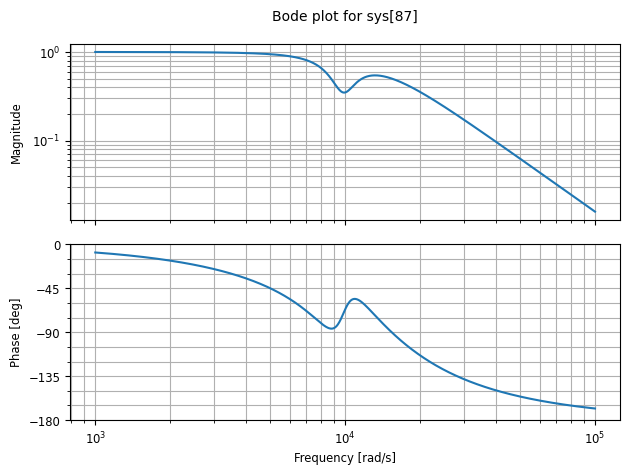

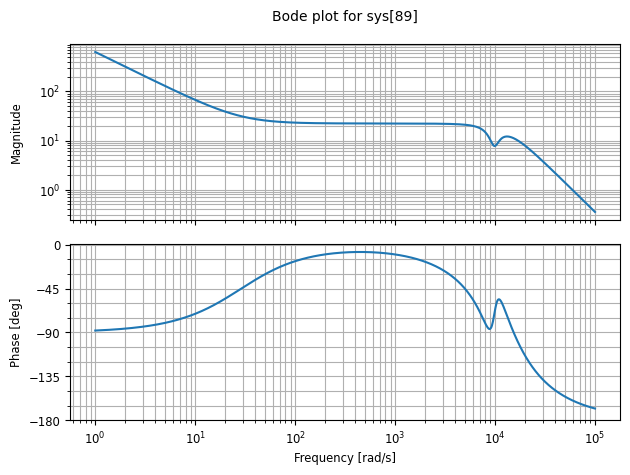

In [15]:
print(ast.speed_ctrl_params)

speed_ctrl = ast.speed_ctrl_params

C = speed_ctrl.Kp*(1 + 1/(s*speed_ctrl.Ti))

assert len(speed_ctrl.act_value_filters) == 0

F = 1 

print("Torque setpoint filters:")

for filt in speed_ctrl.current_setp_filters:
    print(filt)
    if isinstance(filt,tt.tracetypes.PT2):
        pt2i = tt.sinu_tf.PT2(filt.freq,filt.damping)
        F *= pt2i
    elif isinstance(filt,tt.tracetypes.SecondOrdFilter):
        pt2i = tt.sinu_tf.PT2(filt.den_f,filt.den_d) / tt.sinu_tf.PT2(filt.num_f,filt.num_d)
        F *= pt2i
    else:
        raise Exception('Only PT2 filter supported for now..')
    



ctrl.bode(F)
plt.figure()
ctrl.bode(F*C)



0 states have been removed from the model
10 states have been removed from the model


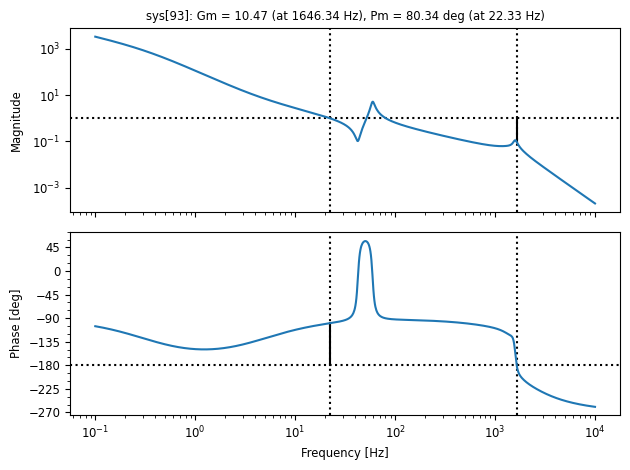

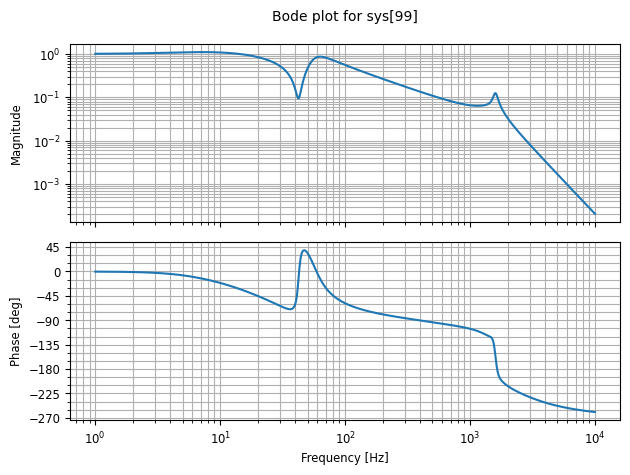

In [16]:

L = C*F*Gf
L = ctrl.minreal(L)

ctrl.bode(L,display_margins=True,Hz=True)   


plt.figure()

CL = L/(1+L)
CL = ctrl.minreal(CL)

ctrl.bode(CL,Hz=True)

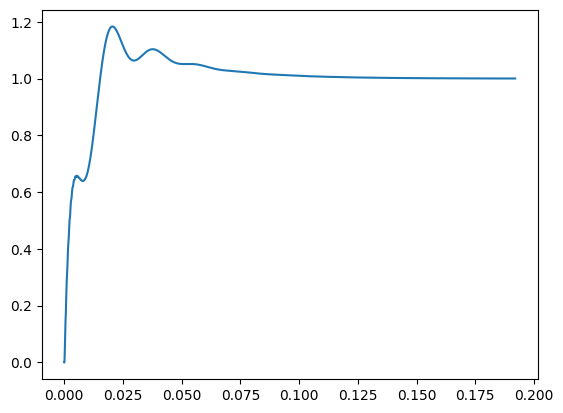

In [17]:

t,y = ctrl.step_response(CL)
plt.plot(t,y)